


# Create Tanaka Contour in Python

by Xuezhi Cang 


<br>
xcang1@niu.edu



## Background



Contour lines are lines drawn on a map connecting the points of equal elevation. They are one of the basic methods to represent the landform relif. An experienced cartographer can read the contour line map to figure out the landform features, such as peak, sink, ridge etc. However, reading the contour is hard for less experienced users when they cannot distingish the difference between the concave area and convex elevation area.  



For example: The image below is a part of contour map. Without the elevation label, it is hard to figure out wheteher it is a hill or a dry lake.

<br>
<br>

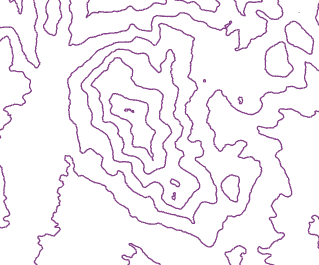

**convex area? convace area?**

To help the users to understand the contour map, Professor Tanaka Kitiro developed a contour mapping method which applied light source (normorlly at 315 &deg;) to a contour map and set different colors to the contour lines on the different hillslopes. The result is a relief-like representation and can help the user to distinguish concave area and convex area.

Tanaka contour:
<br>
<br>
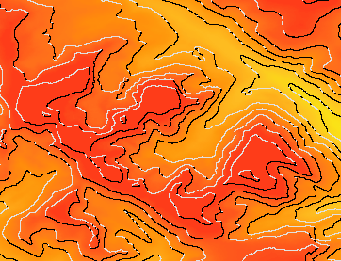

## Objective

Let us create the beautiful Tanaka contour together in this lab.

We will learn to:
- calculate aspect from raster data
- generate contour line shapefile from the DEM data
- reclassify a raster data
- convert vector data(shapefile) to raster data(TiFF)
- plot the vector and raster data in the jupyter notebook.

## How to

### Upload the DEM data



- click the **Mount Drive** icon and click the **connect to google drive** button in the [pop-up window](https://)
<br>
<br>
<br>

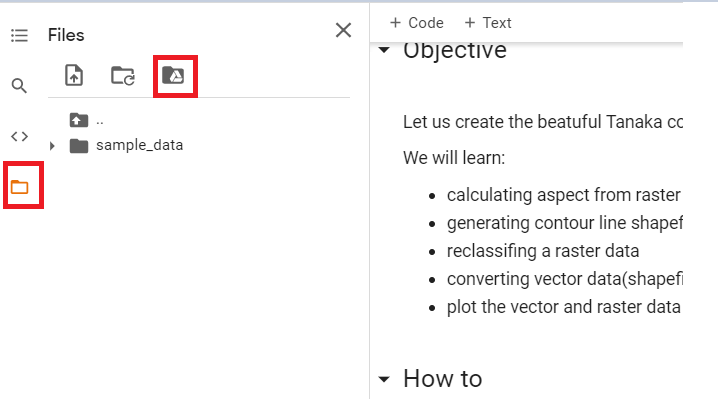

- create a new folder in the **Mydrive** folder and upload your DEM TIFF file

<br>
<br>

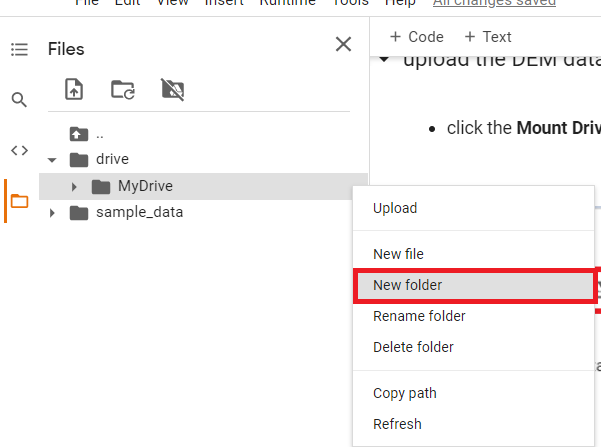

### Import libraries

In [1]:
# import the required libraries
import gdal # opensourse geospatial library
from osgeo import ogr,osr # opensourse geospatial library
import numpy as np # matrix operation library 
import matplotlib.pyplot as plt # ploting library
import copy # library for coping 



In [2]:
# install the geopandas library, which is an opensourse geospatial library 
!pip install geopandas

In [3]:
# import the geopandas after we installed it
import geopandas as gpd

### Import the DEM raster

In [4]:
# assign the location of the raster data
DEM_file_name = "/content/drive/MyDrive/denver_DEM/N40W106.tif"
# open the DEM by using GDAL
gdal_data_DEM = gdal.Open(DEM_file_name)

In [5]:

DEM_data = gdal_data_DEM.GetRasterBand(1)

# convert raster data to a numpy array and change the data type to float
data_array = gdal_data_DEM.ReadAsArray().astype(np.float)


In [6]:
DEM_max = np.max(data_array)
DEM_min = np.min(data_array)
print("the highest elevation in this area is "+ str(DEM_max))
print("the loweast elevation in this area is "+ str(DEM_min))

the highest elevation in this area is 4333.0
the loweast elevation in this area is 1466.0


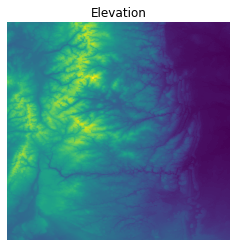

In [7]:
#Plot DEM data by using Matplotlib
fig = plt.figure(figsize = (4, 4))
plt.contourf(data_array, cmap = "viridis",levels = list(range(int(DEM_min), int(DEM_max), 20)))
plt.title("Elevation")
#cbar = plt.colorbar()
#plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

### Calculate Aspect


In [8]:
# assign the location and name of the output
aspect_file = "/content/drive/MyDrive/denver_DEM/aspect.tif"
# calculate the aspect
#  computeEdges=True would force the program to compute the aspect of cells on the edge
#  zeroForFlat=True would set 0 for flat area. Otherwise, the value in the flat area would be -9999 or NoData
aspect_data = gdal.DEMProcessing(aspect_file,DEM_file_name,"aspect",computeEdges=True,zeroForFlat=True)

The values in the aspect data represent the angle of hillslop, so the value should be in the [0,360]

Let us check the min and max value in the aspect raster data.

In [9]:

asp_array = aspect_data.GetRasterBand(1).ReadAsArray()
asp_max = np.max(asp_array)
asp_min = np.min(asp_array)
print("Min value in the asp_array is " + str(asp_min))
print("Max value in the asp_array is " + str(asp_max) )

Min value in the asp_array is 0.0
Max value in the asp_array is 359.8964


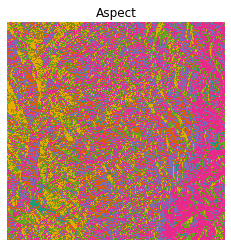

In [10]:
#Plot Aspect data by using Matplotlib
fig = plt.figure(figsize = (4, 4))
plt.imshow(asp_array, cmap = "Dark2")
plt.title("Aspect")
#cbar = plt.colorbar()
#plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

Great! We have the aspect raster data now!

### Reclassify the aspect raster data

As we mentioned in the **Background** part, the Tanaka contour sets different colors to contours based on their location (ligh-receiving hillslope or shady hillslope). Here, we assume that light source is at the Northwest(315 &deg;) We reclassify the ligh-receiving hillslope(0\~45 or 225\~360) to 1 and assign the shady hillslope (45 ~225) to -1.

In [11]:
# copy the asparray
asp_array_reclass = copy.deepcopy(asp_array)

# Get the shape of the asp array
asp_shape = np.shape(asp_array)

# reclassification 
asp_array_reclass[np.where((asp_array_reclass >= 0) & (asp_array_reclass < 45)) ] = 1
asp_array_reclass[np.where((asp_array_reclass >= 45) & (asp_array_reclass < 225)) ] = -1
asp_array_reclass[np.where((asp_array_reclass >=225 ) & (asp_array_reclass <= 360)) ] = 1


In [12]:
# show the min and max value in the asp_array_reclass 
print("Min value in the asp_array_reclass is " + str(np.min(asp_array_reclass)))
print("Max value in the asp_array_reclass is " + str(np.max(asp_array_reclass)))

Min value in the asp_array_reclass is -1.0
Max value in the asp_array_reclass is 1.0


### Create contour line

In [13]:
#Generate layer to save Contourlines
dst_contour_filename = "/content/drive/MyDrive/denver_DEM/contour"
ogr_ds = ogr.GetDriverByName("ESRI Shapefile").CreateDataSource(dst_contour_filename+".shp")
contour_shp = ogr_ds.CreateLayer(dst_contour_filename)

# create the schema of the table
field_defn = ogr.FieldDefn("ID", ogr.OFTInteger)
contour_shp.CreateField(field_defn)
field_defn = ogr.FieldDefn("elev", ogr.OFTReal)
contour_shp.CreateField(field_defn)

# Generate Contour lines
#  the first parameters in the function is the DEM;
#  the second one is the interval of contour
#  More details can be found in https://gdal.org/python/index.html
gdal.ContourGenerate(DEM_data, 150,0,[],0,0,contour_shp,0,1)
del ogr_ds

In [14]:
# read the contour shapefile to the geopandas
contour_gpd = gpd.read_file(dst_contour_filename+".shp")

In [15]:
# show the first five line of the contour data
print(contour_gpd.head())

   ID    elev                                           geometry
0   0  2250.0  LINESTRING Z (-105.38042 41.00014 2250.00000, ...
1   1  2250.0  LINESTRING Z (-105.20274 41.00014 2250.00000, ...
2   2  2250.0  LINESTRING Z (-105.30884 41.00014 2250.00000, ...
3   3  2250.0  LINESTRING Z (-105.35722 40.99943 2250.00000, ...
4   4  2400.0  LINESTRING Z (-105.48546 40.99889 2400.00000, ...


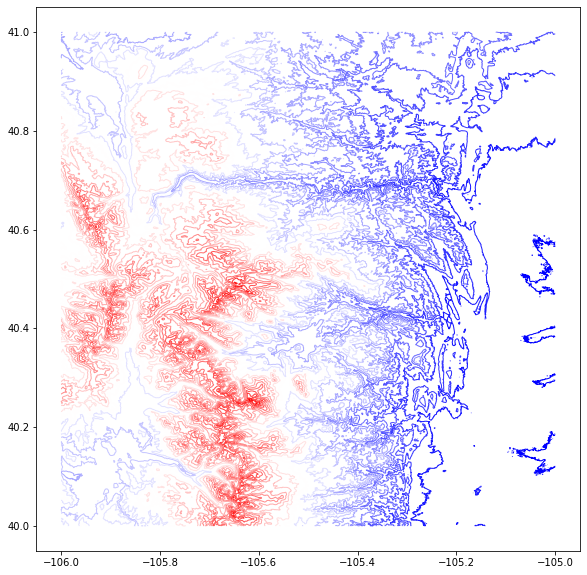

In [16]:
# visualize the contour lines
fig, ax = plt.subplots(1, 1,figsize = (10, 10))
contour_gpd.plot(column='elev',cmap = "bwr",ax=ax,linewidth=1)
plt.show()

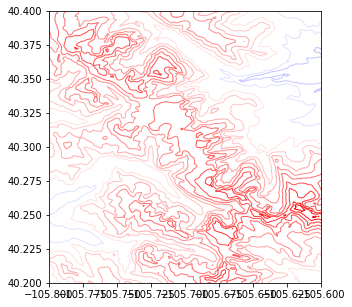

In [17]:
# visualize the contour lines in a zoom-in view

fig, ax = plt.subplots(1, 1,figsize = (5, 5))
contour_gpd.plot(column='elev',cmap = "bwr",ax=ax,linewidth=1)
# set range of x
ax.set_xlim(-105.8, -105.6)
# set range of y
ax.set_ylim(40.2,40.4)
plt.show()
  

### Rasterize (convert the vector data to the raster layer)

To resterize a vector data, we need to create an empty rater data first. Then, we draw the vector data to the empty raster data.

In [18]:
# set the spatial reference of the contour_gpd
# 4326 is the EPSG identifier of WGS84
contour_gpd.set_crs(epsg=4326, inplace=True)
contour_gpd.head()

,ID,elev,geometry
0,0,2250.0,"LINESTRING Z (-105.38042 41.00014 2250.00000, ..."
1,1,2250.0,"LINESTRING Z (-105.20274 41.00014 2250.00000, ..."
2,2,2250.0,"LINESTRING Z (-105.30884 41.00014 2250.00000, ..."
3,3,2250.0,"LINESTRING Z (-105.35722 40.99943 2250.00000, ..."
4,4,2400.0,"LINESTRING Z (-105.48546 40.99889 2400.00000, ..."


In [19]:
contour_shp_withprj = "/content/drive/MyDrive/denver_DEM/contour_withprj.shp"
contour_gpd.to_file(contour_shp_withprj)

In [20]:
# since the new spatial reference information is the same as the DEM data,
#   we obtain the spatial ference information from the DEM and assign them to the new raster data 
ras_daataset = gdal_data_DEM
geot_info = ras_daataset.GetGeoTransform()

#The geot_info includes the infomation of the Upper Left corner coordinates, x and y resolution, and rotation
#More details can be found in https://gdal.org/api/gdaldataset_cpp.html#_CPPv4N11GDALDataset15GetGeoTransformEPd

print(geot_info)

(-106.00013888888888, 0.000277777777777779, 0.0, 41.00013888888889, 0.0, -0.00027777777777777707)


In [21]:
#dst_filename = "/content/drive/MyDrive/denver_DEM/contour"
contourline_dataset = ogr.Open(contour_shp_withprj)
shape_layer = contourline_dataset.GetLayer()

In [22]:
# create an empty raster
drv_tiff = gdal.GetDriverByName("GTiff") 
output_raster = "/content/drive/MyDrive/denver_DEM/count_ra_1.tif"
chn_ras_ds = drv_tiff.Create(output_raster, ras_daataset.RasterXSize, ras_daataset.RasterYSize, 1, gdal.GDT_Float32)
chn_ras_ds.SetGeoTransform(geot_info)

0

In [23]:
# draw the vector data on the raster data
gdal.RasterizeLayer(chn_ras_ds, [1], shape_layer, options=["ATTRIBUTE=elev"])
chn_ras_ds.GetRasterBand(1).SetNoDataValue(-9999) 

chn_ras_ds = None

In [24]:
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

0

In [25]:
# Plot the contour raster data
gdal_data_contour_raster = gdal.Open(output_raster)
gdal_data_contour_raster.SetProjection(srs.ExportToWkt())
contour_ra_array = gdal_data_contour_raster.ReadAsArray()#.astype(np.float)


proj = osr.SpatialReference(wkt=gdal_data_contour_raster.GetProjection())
space = proj.GetAttrValue('AUTHORITY',1)
print("EPSG :" + str(space))

EPSG :4326


In [26]:
print("the max elevatation is: " + str(np.nanmax(contour_ra_array)))
print("the min elevatation is: " + str(np.nanmin(contour_ra_array)))


the max elevatation is: 4200.0
the min elevatation is: 0.0


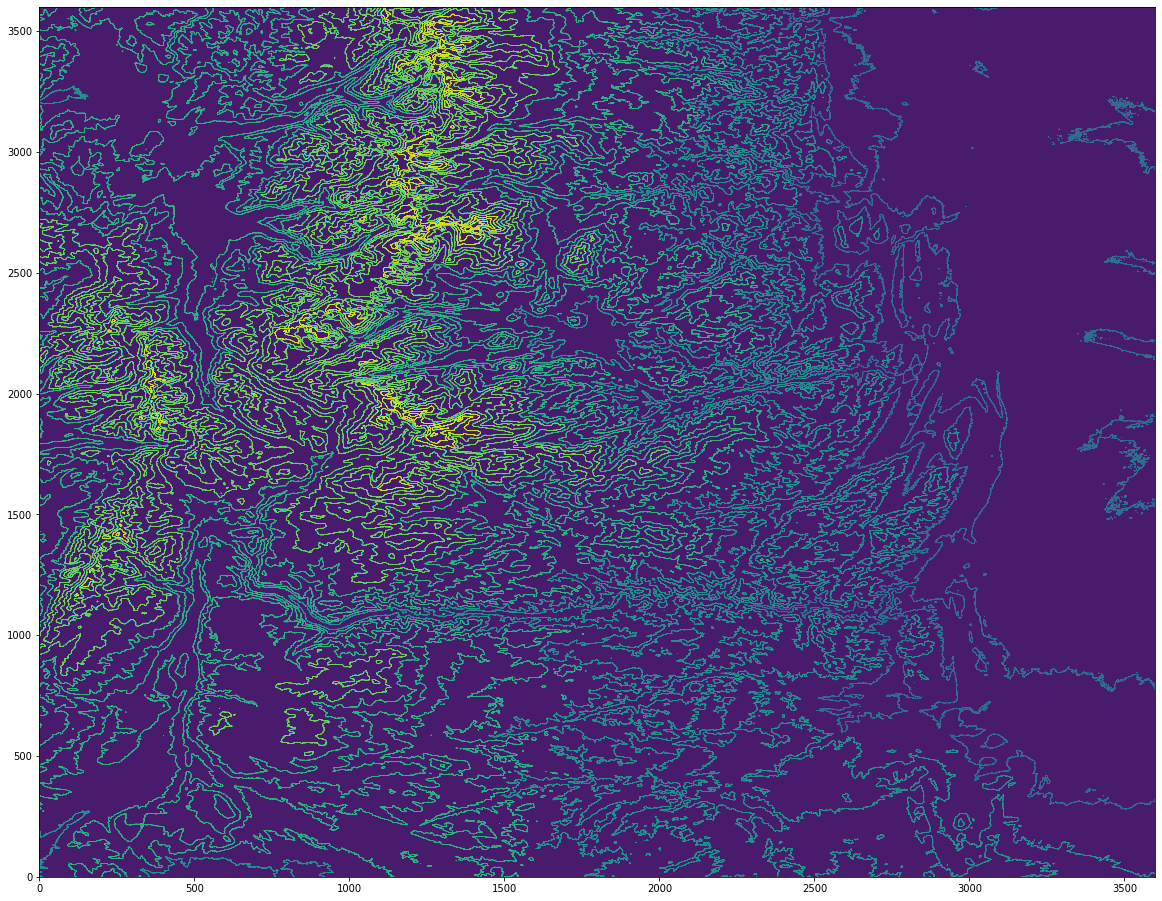

In [27]:
fig = plt.figure(figsize = (20, 16))

plt.contourf(contour_ra_array)

plt.show()

### Combine the Aspect and Contour raster to create the Tanaka contour


In [61]:
tanaka_contour_arr = contour_ra_array *asp_array_reclass

In [62]:
# reclassification 
tanaka_contour_arr[tanaka_contour_arr>1] = -1
tanaka_contour_arr[tanaka_contour_arr<-1 ] = 1


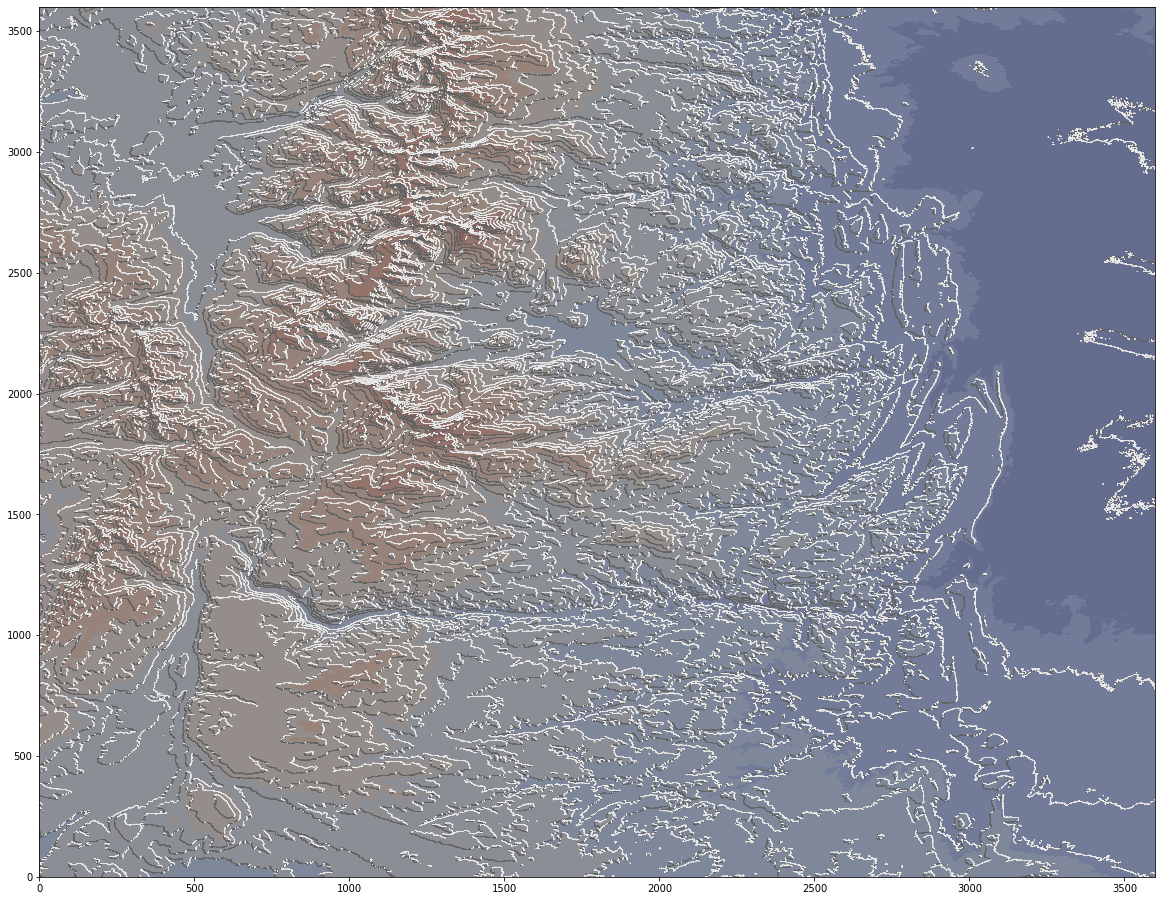

In [63]:
fig = plt.figure(figsize = (20, 16))


plt.contourf(data_array, cmap = "coolwarm")
plt.contourf(tanaka_contour_arr,cmap = 'gray',alpha = 0.7)

plt.show()

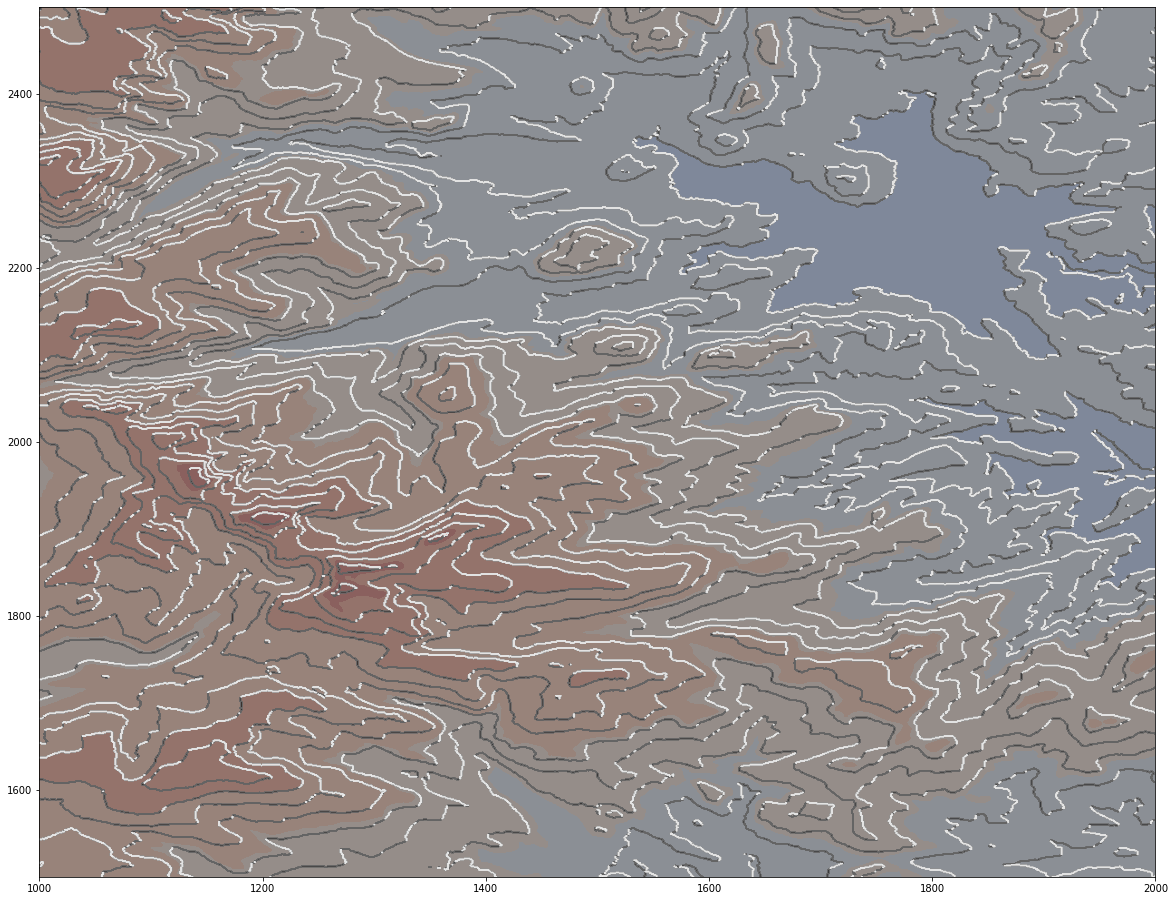

In [64]:
# zoom-in view
fig = plt.figure(figsize = (20, 16))

plt.xlim(1000,2000)
plt.ylim(1500,2500)
plt.contourf(data_array, cmap = "coolwarm")
plt.contourf(tanaka_contour_arr,cmap = 'gray',alpha = 0.7)

plt.show()

## Challenge

### 1. Make your own Tanaka contour map by setting the light source at the southeast cornor(135&deg;).


In this lab, we set the light at the northwest cornor, so the 0&deg; \~ 45&deg; and 225&deg; \~ 360 &deg; are the light-receiving hillslop. 

Could you make a Tanaka contour map, whose light source is at the sourtheast corner, and compare the differences between the new Tanaka map and the Tanaka contour we made in this lab?

###2. Compare the Tanaka contour mapping method by using ArcPy with the method in the lab

We also attached an .ipynb file in the folder by using the ArcPy library. Compare the difference between them. Which one would you like better? Why?

###3. Make your own Tanaka contour by using the SRTM.py (For graduate students)


Although we can download, merge, and clip the DEM of the area in which we are  instrested by using ArcGIS Pro or QGIS manually, we can also use the SRTM.py to obtain the elevations freely. 

Please follow the codes below and create your own Tanaka contour.

In [33]:
!pip install git+https://github.com/tkrajina/srtm.py

  Cloning https://github.com/tkrajina/srtm.py to /tmp/pip-req-build-ckof9nuk
  Running command git clone -q https://github.com/tkrajina/srtm.py /tmp/pip-req-build-ckof9nuk
  Created wheel for SRTM.py: filename=SRTM.py-0.3.7-cp37-none-any.whl size=110305 sha256=59c20eae9db54a54b38c6e6a4a660b8ec0d1a85f2948e756c851e88ab2b2328a
  Stored in directory: /tmp/pip-ephem-wheel-cache-hdxv4ghx/wheels/3f/11/2b/cda4e9c65a3159509a02a1ecf053a0ca2f2130ee3babf3cfda
Successfully built SRTM.py


In [34]:
# import the srtm library
import srtm

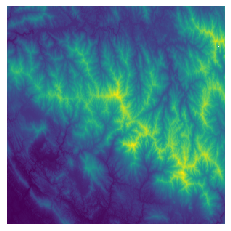

In [35]:
# Example codes for getting the elevations

geo_elevation_data = srtm.get_data()

# The obtained area is the Great Smoky Mountains National Park,
#   you can choose your own area.
# In the code below, (300, 300) is the size of image, 
#                    (35.4, 35.8) is the latitude_interval,
#                    (-83.90, -83.1) is the longitude_interval, 
#                    9999 is the max_elevation,
#                     mode='array' means that the output is numpy array.
# more details can be found in https://github.com/tkrajina/srtm.py/blob/master/srtm/data.py
new_DEM = geo_elevation_data.get_image((300, 300), (35.4, 35.8), (-83.90, -83.1),9999, mode='array')

# Plot the DEM
plt.imshow(new_DEM, interpolation='none')
plt.axis('off')
plt.show()

What is the next step?

1. You may need to convert the array to the TIFF with the spatial reference information which is readable for GDAL library first.
2. You need to create your aspect raster data and contourline vector data from your own DEM data.
3. Then, you can create your own Tanaka contourlines.


